In [98]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


In [99]:
MODEL_N = '13'
SOURCES = './scores/'

In [100]:
# Make a list of data csv-files in source directory
train_score_file = ''
train_loss_file = ''
valid_score_files = []
valid_loss_files = []
test_score_files = []
test_loss_files = []
for root, dirs, files in os.walk(SOURCES):
    files.sort()
    for file in files:
        if file.startswith(f'scores_train_m{MODEL_N}') and file.endswith('.csv'):
            train_score_file = file
        elif file.startswith(f'batch_losses_train_m{MODEL_N}') and file.endswith('.csv'):
            train_loss_file = file
        elif file.startswith(f'scores_val_m{MODEL_N}') and file.endswith('.csv'):
            valid_score_files.append(file)
        elif file.startswith(f'batch_losses_val_m{MODEL_N}') and file.endswith('.csv'):
            valid_loss_files.append(file)
        elif file.startswith(f'scores_test_m{MODEL_N}') and file.endswith('.csv'):
            test_score_files.append(file)
        elif file.startswith(f'batch_losses_test_m{MODEL_N}') and file.endswith('.csv'):
            test_loss_files.append(file)


In [101]:
# Load the scores files
train_scores = []
ts = pd.read_csv(SOURCES + train_score_file, delimiter=',')
train_scores.append(ts)
valid_scores = []
for score_file in valid_score_files:
    df = pd.read_csv(SOURCES + score_file, delimiter=',')
    valid_scores.append(df)
test_scores = []
for score_file in test_score_files:
    df = pd.read_csv(SOURCES + score_file, delimiter=',')
    test_scores.append(df)

In [102]:
# Load the losses files
train_losses = []
tl = pd.read_csv(SOURCES + train_loss_file, delimiter=',')
train_losses.append(tl.T)
valid_losses = []
for loss_file in valid_loss_files:
    df = pd.read_csv(SOURCES + loss_file, delimiter=',')
    valid_losses.append(df.T)
test_losses = []
for loss_file in test_loss_files:
    df = pd.read_csv(SOURCES + loss_file, delimiter=',')
    test_losses.append(df.T)


In [103]:
def add_cumul_scores(scrs):
    # Add cumulative scores
    cumulated = scrs
    cols = ['tp', 'tn', 'fp', 'fn']
    for scr in cumulated:
        for col in cols:
            n_col = 'sum_' + col
            scr[n_col] = scr[col].cumsum()
        scr['sum_precision'] = (scr['sum_tp'] / (scr['sum_tp'] + scr['sum_fp'] + 1e-12))
        scr['sum_recall'] = (scr['sum_tp'] / (scr['sum_tp'] + scr['sum_fn'] + 1e-12))
        scr['sum_f_score'] = (2 * scr['sum_precision'] * scr['sum_recall'])/(scr['sum_precision'] + scr['sum_recall'])
    return cumulated

In [104]:
train_scores = add_cumul_scores(train_scores)
valid_scores = add_cumul_scores(valid_scores)
test_scores = add_cumul_scores(test_scores)

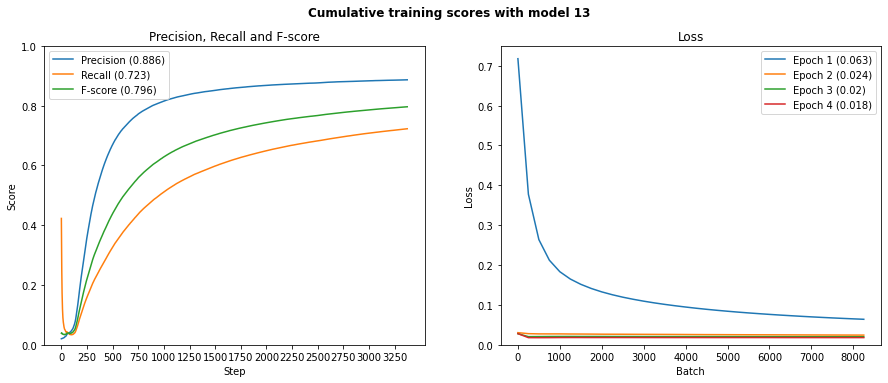

In [105]:
# TRAINING SCORES
plt.rcParams['figure.figsize'] = [15, 5.5]
plt.rcParams['savefig.facecolor'] = 'white'
fig, (sco_ax, los_ax) = plt.subplots(1, 2)
fig.suptitle(f'Cumulative training scores with model {MODEL_N}',fontweight = "bold")
sco_ax.title.set_text('Precision, Recall and F-score')
sco_ax.set_ylim(0.0, 1.0)
sco_ax.plot(train_scores[0].sum_precision, label = f'Precision ({round(train_scores[0].sum_precision.iloc[-1], 3)})')
sco_ax.plot(train_scores[0].sum_recall, label = f'Recall ({round(train_scores[0].sum_recall.iloc[-1], 3)})')
sco_ax.plot(train_scores[0].sum_f_score, label = f'F-score ({round(train_scores[0].sum_f_score.iloc[-1], 3)})')
sco_ax.set_xticks(list(train_scores[0].index)[0::250])
sco_ax.set_xticklabels(list(train_scores[0].index)[0::250])
sco_ax.set_xlabel('Step')
sco_ax.set_ylabel('Score')
sco_ax.legend()
los_ax.title.set_text('Loss')
max_loss = 0
i = 0
while i < len(train_losses[0].T):
    los_ax.plot(train_losses[0][i][0::250], label = f'Epoch {i + 1} ({round(train_losses[0][i].iloc[-1], 3)})')
    max_loss = max(max_loss, round(max(list(train_losses[0][i])),1) + 0.05)
    i += 1
los_ax.set_ylim(0.0, max_loss)
los_ax.set_xticks(list(train_losses[0][0].index)[0::1000])
los_ax.set_xticklabels(list(train_losses[0][0].index)[0::1000])
los_ax.set_xlabel('Batch')
los_ax.set_ylabel('Loss')
los_ax.legend()
fig.savefig(f'scores/training-scores-m{MODEL_N}')

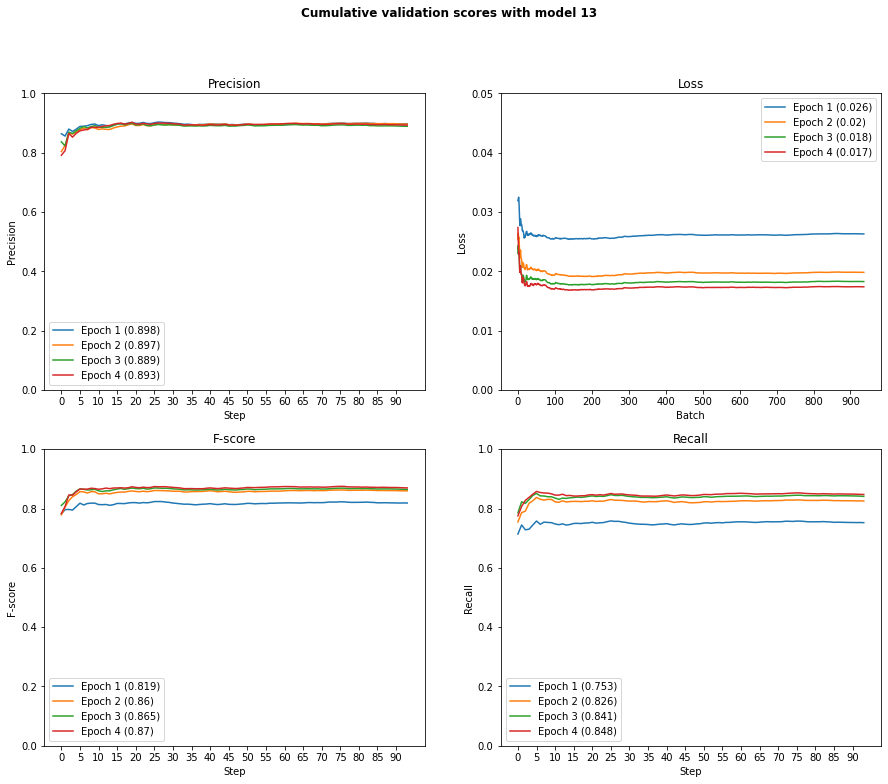

In [106]:
# Validation scores
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['savefig.facecolor'] = 'white'
fig, ((pre_ax, los_ax), (fsc_ax, rec_ax)) = plt.subplots(2, 2)
fig.suptitle(f'Cumulative validation scores with model {MODEL_N}',fontweight = "bold")
pre_ax.title.set_text('Precision')
pre_ax.set_ylim(0.0, 1.0)
i = 0
while i < len(valid_scores):
    pre_ax.plot(valid_scores[i].sum_precision, label = f'Epoch {i + 1} ({round(valid_scores[i].sum_precision.iloc[-1], 3)})')
    i += 1
pre_ax.set_xticks(list(valid_scores[0].index)[0::5])
pre_ax.set_xticklabels(list(valid_scores[0].index)[0::5])
pre_ax.set_xlabel('Step')
pre_ax.set_ylabel('Precision')
pre_ax.legend()
los_ax.title.set_text('Loss')
max_loss = 0
i = 0
while i < len(valid_losses):
    los_ax.plot(valid_losses[i], label = f'Epoch {i + 1} ({round(float(valid_losses[i].iloc[-1]), 3)})')
    max_loss = max(max_loss, round(max(list(valid_losses[i][0])),1) + 0.05)
    i += 1
los_ax.set_ylim(0.0, max_loss)
los_ax.set_xticks(list(valid_losses[0].index)[0::100])
los_ax.set_xticklabels(list(valid_losses[0].index)[0::100])
los_ax.set_xlabel('Batch')
los_ax.set_ylabel('Loss')
los_ax.legend()
rec_ax.title.set_text('Recall')
rec_ax.set_ylim(0.0, 1.0)
i = 0
while i < len(valid_scores):
    rec_ax.plot(valid_scores[i].sum_recall, label = f'Epoch {i + 1} ({round(valid_scores[i].sum_recall.iloc[-1], 3)})')
    i += 1
rec_ax.set_xticks(list(valid_scores[0].index)[0::5])
rec_ax.set_xticklabels(list(valid_scores[0].index)[0::5])
rec_ax.set_xlabel('Step')
rec_ax.set_ylabel('Recall')
rec_ax.legend()
fsc_ax.title.set_text('F-score')
fsc_ax.set_ylim(0.0, 1.0)
i = 0
while i < len(valid_scores):
    fsc_ax.plot(valid_scores[i].sum_f_score, label = f'Epoch {i + 1} ({round(valid_scores[i].sum_f_score.iloc[-1], 3)})')
    i += 1
fsc_ax.set_xticks(list(valid_scores[0].index)[0::5])
fsc_ax.set_xticklabels(list(valid_scores[0].index)[0::5])
fsc_ax.set_xlabel('Step')
fsc_ax.set_ylabel('F-score')
fsc_ax.legend()
fig.savefig(f'scores/validation-scores-m{MODEL_N}')